 # Graph Neural Ordinary Differential Equations Poli et al. 2019.
 Goal: Reproduce the Node classification experiment in this paper.

Here is the their code: https://github.com/Zymrael/gde

# 1. Import all the packages

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import networkx as nx

## 1.1 Install the Deep Graph Library (DGL), which include datasets we need.


In [2]:
pip install dgl

In [3]:
import dgl
import dgl.data

# 2. Data Preparation

## 2.1 Cora dataset

USed to do Node Classification Task

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [5]:
dataset = dgl.data.CoraGraphDataset()

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [6]:
data = dataset[0] #only one graph is contained in this dataset
print(data)

Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})


In [7]:
X = data.ndata['feat'].to(device)   # feature matrix
Y = data.ndata['label'].to(device)  # true classification label of each node
print('dimension of node features is ',X.shape[1])
print('number of classes is ',dataset.num_classes)

dimension of node features is  1433
number of classes is  7


In [8]:
train_mask  = data.ndata['train_mask']
test_mask   = data.ndata['test_mask']
val_mask    = data.ndata['val_mask']
print('training set   ', train_mask.sum().item())
print('testing set    ',test_mask.sum().item())
print('validation set ',val_mask.sum().item())

training set    140
testing set     1000
validation set  500


In [9]:
adj_mat = data.adj().indices().to(device) # adjacency matrix edge index, used in GCN layer
print(adj_mat)

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])


# 3. Model Construction

## 3.1 install torchdiffeq


In [10]:
pip install torchdiffeq
from torchdiffeq import odeint

In [11]:
pip install torch-geometric
from torch_geometric.nn import GCNConv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.8/398.8 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.7/83.7 kB 9.1 MB/s eta 0:00:00


## 3.1 build our model

Totally 4 layers:

* First layer is a GCN layer with dropout rate 0.4, activation function Relu. (input_dim = dim_feature,output_dim = 64)
  * This first layer is just used to reduce the dimension of the node features.
* ODE step:
  * Construct a two-layer model, each is a GCN layer with dropout rate 0.9, activation function Softplus. (input_dim = 64,output_dim=64)
  * apply odeint for this model
  * the output of this step is the final embedding of nodes
* Last layer is a GCN layer with no dropout and no activation function. (input_dim = 64,output_dim=num_classes)
  * this last layer works like classifcation layer.



In [34]:
class GCNLayer(nn.Module):
  def __init__(self,in_dim,out_dim,activation,dropout):
    super(GCNLayer, self).__init__()
    self.convs = GCNConv(in_dim,out_dim,normalize=True)
    self.convs.bias = nn.Parameter(torch.Tensor(out_dim))
    self.convs.lin.weight = nn.Parameter(torch.Tensor(out_dim, in_dim))

    self.activation = activation
    self.dropout = nn.Dropout(p=dropout)
    self.reset_parameters()

  def reset_parameters(self):
    stdv = 1. / math.sqrt(self.convs.lin.weight.size(1))
    self.convs.lin.weight.data.uniform_(-stdv, stdv)
    if self.convs.bias is not None:
      self.convs.bias.data.uniform_(-stdv, stdv)


  def forward(self, h, adj):
    if self.dropout:
      h = self.dropout(h)

    h = self.convs(h,adj)

    if self.activation:
      h = self.activation(h)

    return h


class GCNfunc(nn.Module):
  def __init__(self, adj, hidden_dim, activation, method):
    super(GCNfunc,self).__init__()

    self.adj = adj
    self.hidden_layers = torch.nn.ModuleList()

    if method == 'dopri5':
      self.hidden_layers.append(GCNLayer(hidden_dim, hidden_dim, activation, dropout = 0.9))
    else:
      self.hidden_layers.append(GCNLayer(hidden_dim, hidden_dim, activation, dropout = 0.9))
      self.hidden_layers.append(GCNLayer(hidden_dim, hidden_dim, activation = None, dropout = 0.9))

  def forward(self,t,h):
    for i in range(len(self.hidden_layers)):
      h = self.hidden_layers[i](h,self.adj)
    return h



class GCDE(nn.Module):
  def __init__(self, adj, input_dim, hidden_dim,output_dim, activation, method, s, rtol, atol):
    super(GCDE, self).__init__()


    self.adj = adj
    self.method = method
    self.integration_time = torch.tensor([0, s]).float().to(device)
    self.rtol = rtol
    self.atol = atol


    self.input_layer = GCNLayer(input_dim, hidden_dim, F.relu, dropout = 0.6)

    self.odefunc = GCNfunc(self.adj,hidden_dim,activation,method)

    self.output_layer = GCNLayer(hidden_dim,output_dim, activation = None, dropout = 0)


  def forward(self,h):
    h = self.input_layer(h,self.adj)
    h = odeint(self.odefunc, h, self.integration_time,rtol=self.rtol, atol=self.atol, method=self.method)[-1]
    h = self.output_layer(h,self.adj)

    return h





In [35]:
model = GCDE(adj_mat,X.shape[1],64,dataset.num_classes,nn.Softplus(),method = 'rk4',s=1,rtol=1e-4,atol = 1e-3).to(device)

In [36]:
for name, param in model.named_parameters():
    print(f"Name: {name}, Value: {param}, Shape: {param.shape}")


Name: input_layer.convs.bias, Value: Parameter containing:
tensor([-0.0079,  0.0242,  0.0033,  0.0064,  0.0060, -0.0162,  0.0164, -0.0039,
        -0.0247, -0.0188, -0.0038, -0.0075, -0.0235,  0.0184, -0.0253,  0.0112,
        -0.0251, -0.0220,  0.0159,  0.0109, -0.0130,  0.0216, -0.0201, -0.0137,
         0.0065,  0.0245, -0.0026, -0.0206, -0.0117, -0.0233, -0.0168,  0.0054,
        -0.0102,  0.0026, -0.0250,  0.0008, -0.0171, -0.0124, -0.0040, -0.0128,
        -0.0147, -0.0159, -0.0200, -0.0122, -0.0231, -0.0190,  0.0025,  0.0061,
        -0.0029,  0.0153,  0.0223,  0.0023,  0.0149, -0.0049, -0.0204,  0.0173,
         0.0154, -0.0253,  0.0063,  0.0102, -0.0069, -0.0225,  0.0011,  0.0168],
       requires_grad=True), Shape: torch.Size([64])
Name: input_layer.convs.lin.weight, Value: Parameter containing:
tensor([[ 2.1463e-02, -1.9985e-03,  1.8877e-02,  ...,  7.1520e-04,
          1.4680e-02, -1.2855e-02],
        [ 9.2551e-03, -2.4593e-02,  7.9169e-03,  ...,  1.1558e-02,
         -1.6

# 4. Training & Evaluation

## 4.1 Evaluation metric


In [31]:
def accuracy(y_hat,y): # evaluation metric
  preds = torch.max(y_hat, 1)[1]
  return torch.mean((y == preds).float())

## 4.2 Training settings

In [32]:
# training set up
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

epoches = 3000
verbose_step = 15
num_grad_steps = 0
loss_history = []

train_acc_history = []
val_acc_history = []
test_acc_history = []

## 4.3 Training

In [33]:
for i in range(epoches): # looping over epochs
    model.train()

    
    y_pred = model(X)
    loss = criterion(y_pred[train_mask], Y[train_mask])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    num_grad_steps += 1

    loss_history.append(loss.item())

    with torch.no_grad():
        model.eval()

        train_acc = accuracy(y_pred[train_mask], Y[train_mask]).item()
        val_acc = accuracy(y_pred[val_mask], Y[val_mask]).item()
        test_acc = accuracy(y_pred[test_mask], Y[test_mask]).item()

        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        test_acc_history.append(test_acc)


    if num_grad_steps % verbose_step == 0:
        print('[{}], Loss: {:3.3f},train accuracy: {:3.3f},validation accuracy: {:3.3f},test accuracy: {:3.3f}'.format(num_grad_steps,loss.item(),train_acc,val_acc,test_acc))

[15], Loss: 1.970,train accuracy: 0.157,validation accuracy: 0.122,test accuracy: 0.119
[30], Loss: 1.935,train accuracy: 0.214,validation accuracy: 0.184,test accuracy: 0.171
[45], Loss: 1.913,train accuracy: 0.207,validation accuracy: 0.176,test accuracy: 0.178
[60], Loss: 1.931,train accuracy: 0.171,validation accuracy: 0.164,test accuracy: 0.146
[75], Loss: 1.933,train accuracy: 0.207,validation accuracy: 0.234,test accuracy: 0.193
[90], Loss: 1.884,train accuracy: 0.314,validation accuracy: 0.244,test accuracy: 0.244
[105], Loss: 1.873,train accuracy: 0.329,validation accuracy: 0.216,test accuracy: 0.218
[120], Loss: 1.864,train accuracy: 0.386,validation accuracy: 0.300,test accuracy: 0.269
[135], Loss: 1.863,train accuracy: 0.357,validation accuracy: 0.268,test accuracy: 0.275
[150], Loss: 1.838,train accuracy: 0.429,validation accuracy: 0.274,test accuracy: 0.288
[165], Loss: 1.818,train accuracy: 0.471,validation accuracy: 0.318,test accuracy: 0.334
[180], Loss: 1.811,train ac

# 5. Results/Plots

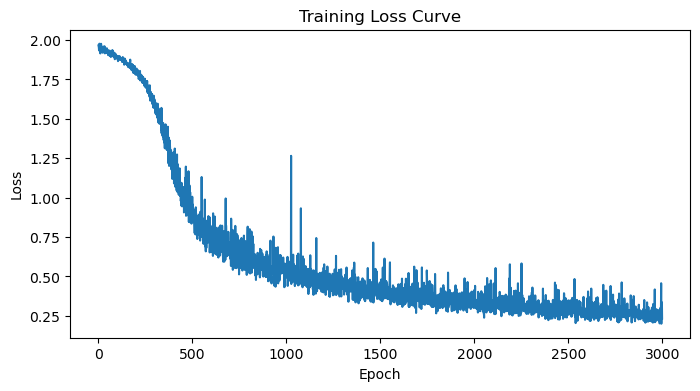

In [26]:
plt.figure(figsize=(8, 4))
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

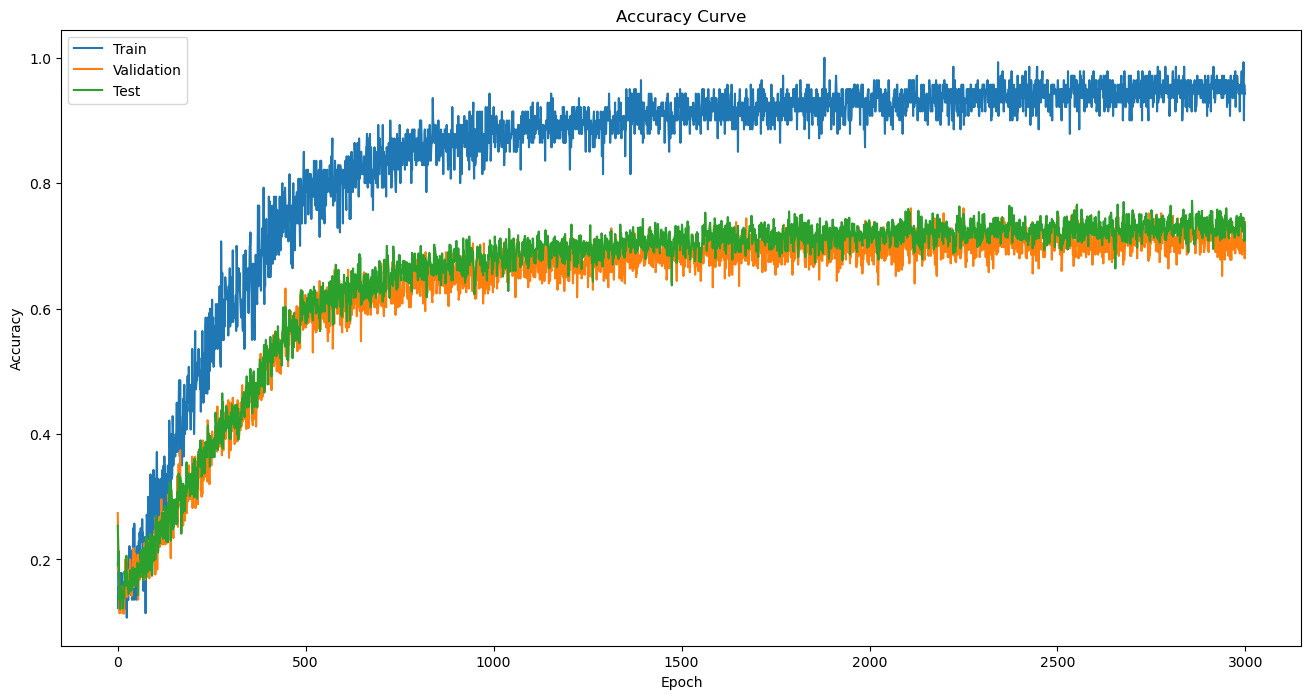

In [27]:
plt.figure(figsize=(16, 8))
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.plot(test_acc_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend(['Train', 'Validation','Test'])
plt.show()

# LOG
## 1. first layer dropout rate 0.6
loss doesn't go down, around 3.0, fixed when using their initialization method
## 2. first layer dropout rate 0.4
loss goes down, lowest around 0.25 (rk4) ,but a little slower than theirs

## 3. Add self-loops to graph (this is what they do, but why?)
* Since $H^{t+1} = \hat{D}^{-1/2}\hat{A}\hat{D}^{-1/2}H^{t}\Theta$, where $\hat{A}=A+I$, which is the adjacency matrix for graph with self-loop
* GCNConv will automatically do that, so I don't need do it manually.


## 4. Try different odeint method rk4/dopri5
* both rk4 and dopri5 give similar validation and test accuracy.
* dopri5 provides smaller training loss (around 0.13), but it is much slower than rk4

## 5. Try different integration time s = 5,10
* s= 5 is not working for rk4 with both drop rate 0.4/0.6
* when s>1, lr is set to 1e-2

## 6. Try their code
dgl does not support mps(gpu on mac), can't run code faster.

## 7. Normalize the initial parameters
* want to do that because when s=1 test accuracy is a little bit lower than their codes, and s=5 does not work.
* add def reset_parameters in model
* s=1, loss reduce faster but the test accuracy still around 0.75 (instead of 0.8 in their paper)


## 8. Other experiments